In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sklearn
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import matplotlib.pyplot as plt
import pickle

In [20]:
#gets new data
def get_data(save_path):
    pickle_off = open(save_path,'rb')
    activity_table=pickle.load(pickle_off)
    pickle_off.close()
    #get length of MFP
    fp_length = len(activity_table.iloc[5]['MFP'])

    le = sklearn.preprocessing.LabelEncoder()
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(copy = False)
    labels = le.fit_transform(activity_table['PUBCHEM_ACTIVITY_OUTCOME'])
    #split data:
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, train_size=None, random_state=2562)
    X_mfp = np.concatenate(np.array(activity_table['MFP'])).ravel()
    X_mfp = X_mfp.reshape((-1,fp_length))
    for train_ind, test_ind in splitter.split(X_mfp,labels):
        # standardize data
        X_train_molchars_std = scaler.fit_transform(np.array(activity_table.iloc[train_ind,4:]))
        X_test_molchars_std = scaler.transform(np.array(activity_table.iloc[test_ind,4:]))
        X_train = np.concatenate((X_mfp[train_ind,:],X_train_molchars_std),axis = 1)
        X_test = np.concatenate((X_mfp[test_ind,:],X_test_molchars_std),axis = 1)
        y_train = labels[train_ind]
        y_test = labels[test_ind]
        #X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,labels,test_size = .5, shuffle = True, stratify = labels, random_state = 2562)
        bin_y_train, bin_y_test = [1 if x ==2 else x for x in y_train],[1 if x ==2 else x for x in y_test]
    return X_train, X_test, y_train, y_test, bin_y_train, bin_y_test
def train_modelfarm(X_train, X_test, y_train, y_test, bin_y_train, bin_y_test,AID,print_report):
    #trains model farm
    #rand forests
    rf = RandomForestClassifier(n_estimators=100, random_state=2562, class_weight="balanced_subsample", n_jobs = -1)
    rand_for = rf.fit(X_train,y_train)
    rf_preds = rand_for.predict(X_test)
    bin_rand_for = rf.fit(X_train,bin_y_train)
    bin_rf_preds = bin_rand_for.predict(X_test)
    #%%
    #adaboost
    adaboost = sklearn.ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=1.0, algorithm='SAMME.R', random_state=2562)
    adaboost_model = adaboost.fit(X_train,y_train)
    adaboost_preds = adaboost_model.predict(X_test)
    bin_adaboost_model = adaboost.fit(X_train,bin_y_train)
    bin_adaboost_preds = bin_adaboost_model.predict(X_test)
    #%%
    #sgd linear svm
    sgd_linear_SVM = sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=100000, 
                                                        tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, 
                                                        validation_fraction=0.1, n_iter_no_change=5, class_weight='balanced', warm_start=False, average=False)
    sgd_linear_SVM_model = sgd_linear_SVM.fit(X_train,y_train)
    sgd_lSVM_preds = sgd_linear_SVM_model.predict(X_test)
    bin_sgd_linear_SVM_model = sgd_linear_SVM.fit(X_train,bin_y_train)
    bin_sgd_lSVM_preds = bin_sgd_linear_SVM_model.predict(X_test)
    #%%
    #simple neural net
    import tensorflow as tf
    import keras
    from keras import backend as K
    from tensorflow.keras.models import Sequential 

    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Lambda
    from tensorflow.keras.utils import to_categorical
    #from https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
    def focal_loss(y_true, y_pred):
        gamma = 2.0
        alpha = 0.25
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    from tensorflow.keras.callbacks import Callback
    from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score


  
    fast_NN = Sequential(name = 'quick')
    fast_NN.add(Dense(512, input_shape = (len(X_test[0,:]),), activation = 'sigmoid', name = 'input'))
    fast_NN.add(Dense(128, activation = 'relu', name = 'first'))
    fast_NN.add(Dense(64, activation = 'relu', name = 'second'))
    fast_NN.add(Dense(16, activation = 'relu', name = 'third'))
    fast_NN.add(Dense(3, activation = 'softmax', name = 'predict'))
    fast_NN.compile(loss = [focal_loss], optimizer='adam',metrics=['categorical_accuracy'])
    fast_NN_model = fast_NN.fit(X_train, to_categorical(y_train),
                 validation_data=(X_test, to_categorical(y_test)),
                 epochs=30,
                 batch_size=500,
                 shuffle=True,
                 verbose=False)
    bin_fast_NN = Sequential(name = 'bin_quick')
    bin_fast_NN.add(Dense(512, input_shape = (len(X_test[0,:]),), activation = 'sigmoid', name = 'input'))
    bin_fast_NN.add(Dense(128, activation = 'relu', name = 'first'))
    bin_fast_NN.add(Dense(64, activation = 'relu', name = 'second'))
    bin_fast_NN.add(Dense(16, activation = 'relu', name = 'third'))
    bin_fast_NN.add(Dense(1, activation = 'sigmoid', name = 'predict'))
    bin_fast_NN.compile(loss = [focal_loss], optimizer='adam',metrics=['categorical_accuracy'])
    bin_fast_NN_model = bin_fast_NN.fit(X_train, to_categorical(bin_y_train),
                 validation_data=(X_test, to_categorical(bin_y_test)),
                 epochs=30,
                 batch_size=500,
                 shuffle=True,
                 verbose=False)
    #make predictions
    NN_test_preds = fast_NN.predict(X_test)
    bin_NN_test_preds = bin_fast_NN.predict(X_test)
    
    
    print(AID)
    print('Random Forests')
    print(sklearn.metrics.classification_report(y_test,rf_preds))
    print('bin_Random Forests')
    print(sklearn.metrics.classification_report(bin_y_test,bin_rf_preds))
    print('adaboost_model')
    print(sklearn.metrics.classification_report(y_test,adaboost_preds))
    print('bin_adaboost_model')
    print(sklearn.metrics.classification_report(bin_y_test,bin_adaboost_preds))
    print('SGD lSVM')
    print(sklearn.metrics.classification_report(y_test,sgd_lSVM_preds))
    print('bin_SGD lSVM')
    print(sklearn.metrics.classification_report(bin_y_test,bin_sgd_lSVM_preds))
    print('NN')
    print(sklearn.metrics.classification_report(y_test,np.argmax(NN_test_preds, axis = 1)))
    print('bin_NN')
    print(sklearn.metrics.classification_report(bin_y_test,np.argmax(bin_NN_test_preds, axis = 1)))
    #print('RBF SVM')
    #print(sklearn.metrics.classification_report(y_test,rbf_SVM_preds))
    #le.inverse_transform([0,1,2])
    multi_roc(NN_test_preds,to_categorical(y_test),'NN_Test',3)
    multi_roc(bin_NN_test_preds,to_categorical(bin_y_test),'bin_NN_Test',2)

def nn_train_plot(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def multi_roc(y_preds,y_true,name,n_classes):
    import collections
    nested_dict = lambda: collections.defaultdict(nested_dict)
    data_store = nested_dict()
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    from itertools import cycle
    lw = 2
    name_store = ['Active', 'Inactive', 'Inconclusive']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true[:, i].ravel(), y_preds[:, i].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of '+ name_store[i]+'(area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Multi-class ROC for '+name+' Split= '+str(count+1))
    plt.title('Multi-class ROC for '+name)

    plt.legend(loc="lower right")
    plt.show()
def train_print_models(save_path,AID):
    X_train, X_test, y_train, y_test, bin_y_train, bin_y_test = get_data(save_path)
    train_modelfarm(X_train, X_test, y_train, y_test, bin_y_train, bin_y_test, AID,True)
   

C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


True
Random Forests
              precision    recall  f1-score   support

           0       0.75      0.22      0.34      2814
           1       0.87      0.99      0.93     31427
           2       0.33      0.03      0.05      2715

   micro avg       0.86      0.86      0.86     36956
   macro avg       0.65      0.41      0.44     36956
weighted avg       0.82      0.86      0.82     36956

bin_Random Forests
              precision    recall  f1-score   support

           0       0.78      0.20      0.32      2814
           1       0.94      1.00      0.97     34142

   micro avg       0.93      0.93      0.93     36956
   macro avg       0.86      0.60      0.64     36956
weighted avg       0.93      0.93      0.92     36956

adaboost_model
              precision    recall  f1-score   support

           0       0.49      0.21      0.29      2814
           1       0.87      0.99      0.92     31427
           2       0.22      0.01      0.01      2715

   micro avg       0

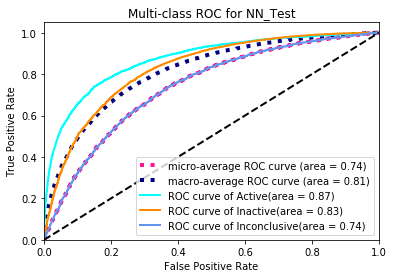

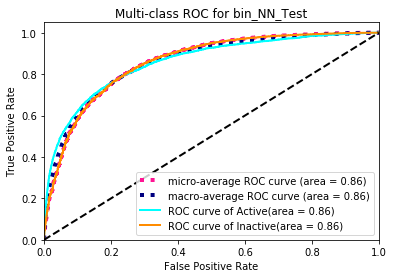

C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


True
Random Forests
              precision    recall  f1-score   support

           0       0.36      0.57      0.44      2274
           1       0.97      0.91      0.94     35440
           2       0.12      0.30      0.17       555

   micro avg       0.88      0.88      0.88     38269
   macro avg       0.48      0.59      0.52     38269
weighted avg       0.92      0.88      0.90     38269

bin_Random Forests
              precision    recall  f1-score   support

           0       0.35      0.63      0.45      2274
           1       0.98      0.93      0.95     35995

   micro avg       0.91      0.91      0.91     38269
   macro avg       0.66      0.78      0.70     38269
weighted avg       0.94      0.91      0.92     38269

adaboost_model
              precision    recall  f1-score   support

           0       0.41      0.11      0.17      2274
           1       0.93      0.99      0.96     35440
           2       0.00      0.00      0.00       555

   micro avg       0

C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


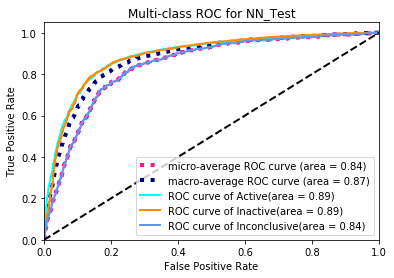

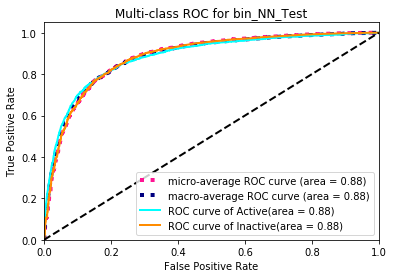

C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\gdrei\Anaconda3\envs\RD_ZONE\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


True
Random Forests
              precision    recall  f1-score   support

           0       0.47      0.14      0.22      3054
           1       0.83      0.90      0.86     29015
           2       0.64      0.62      0.63     14537

   micro avg       0.76      0.76      0.76     46606
   macro avg       0.65      0.55      0.57     46606
weighted avg       0.74      0.76      0.75     46606

bin_Random Forests
              precision    recall  f1-score   support

           0       0.54      0.10      0.17      3054
           1       0.94      0.99      0.97     43552

   micro avg       0.94      0.94      0.94     46606
   macro avg       0.74      0.55      0.57     46606
weighted avg       0.91      0.94      0.91     46606

adaboost_model
              precision    recall  f1-score   support

           0       0.44      0.11      0.17      3054
           1       0.81      0.86      0.83     29015
           2       0.58      0.61      0.60     14537

   micro avg       0

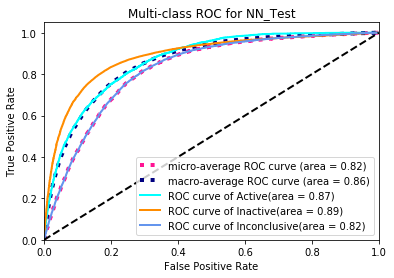

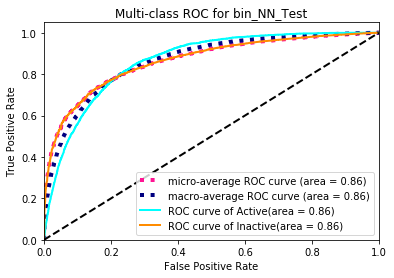

In [21]:
path_list = [['AID_893',r'C:\Users\gdrei\Dropbox\UCL\Thesis\May_13\AID_893_processed.pkl'],['AID_624255',r'C:\Users\gdrei\Dropbox\UCL\Thesis\May_13\AID_624255_processed.pkl'],['AID_1345083',r'C:\Users\gdrei\Dropbox\UCL\Thesis\May_13\AID_1345083_processed.pkl']]
for AID,save_path in path_list:
    train_print_models(save_path,AID)